<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px;">
1. Environment Setup & Data Loading
</div>

In [1]:
# !pip install jinja2
# !pip install catboost
# !pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import uniform, loguniform, randint
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    recall_score,
    precision_score,
    f1_score, 
    roc_auc_score,
    silhouette_score 
)

# --- Display Settings and Warning Handling ---
pd.set_option('display.max_columns', None) 
import warnings
warnings.filterwarnings('ignore') 

# --- Load Data ---
adir=1
if(adir==1):
    base_path = r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data"
else:
    base_path = r"C:\Users\97252\Desktop\Chen_proj\data"

# Load Features (X)
X_train = pd.read_csv(f"{base_path}/X_train.csv")
X_train_noisy = pd.read_csv(f"{base_path}/X_train_noisy.csv")
X_test = pd.read_csv(f"{base_path}/X_test.csv")

# Load Targets (y)
y_train = pd.read_csv(f"{base_path}/y_train.csv").squeeze()
y_test = pd.read_csv(f"{base_path}/y_test.csv").squeeze()

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px;">
2. Advanced Feature Engineering
</div>

In [2]:
# --- 1. Function Definition ---
def apply_feature_engineering(df):

    df = df.copy()

    # 1. Demographic Interactions
    # Check if race matches (ignoring Unknowns)
    df['same_race'] = ((df['PERP_RACE'] == df['VIC_RACE']) & 
                        (df['PERP_RACE'] != 'Unknown')).astype(int)
    
    # Is the suspect information available or missing?
    df['suspect_info_available'] = (df['PERP_AGE_GROUP'] != 'Unknown').astype(int)

    # 2. Cyclical Time Features
    # This helps models understand that 23:00 is close to 00:00
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # 3. Specific Risk Combinations
    # Crimes happening outside at night might have different characteristics
    df['is_night_outdoor'] = ((df['Part_of_Day'] == 'Night') & 
                              (df['LOC_OF_OCCUR_DESC'] == 'OUTSIDE')).astype(int)

    # 4. Vulnerability Features
    # Flagging minor victims
    df['is_minor_victim'] = (df['VIC_AGE_GROUP'] == '<18').astype(int)
    
    return df

# --- 2. Applying the Function to All Sets ---
X_train = apply_feature_engineering(X_train)
X_train_noisy = apply_feature_engineering(X_train_noisy)
X_test = apply_feature_engineering(X_test)

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px;">
3. Handling High Cardinality
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 16px;">
3.1 Analyzing Feature Cardinality & Distribution
</div>

--- Distribution Analysis (Top 20 Categories) ---


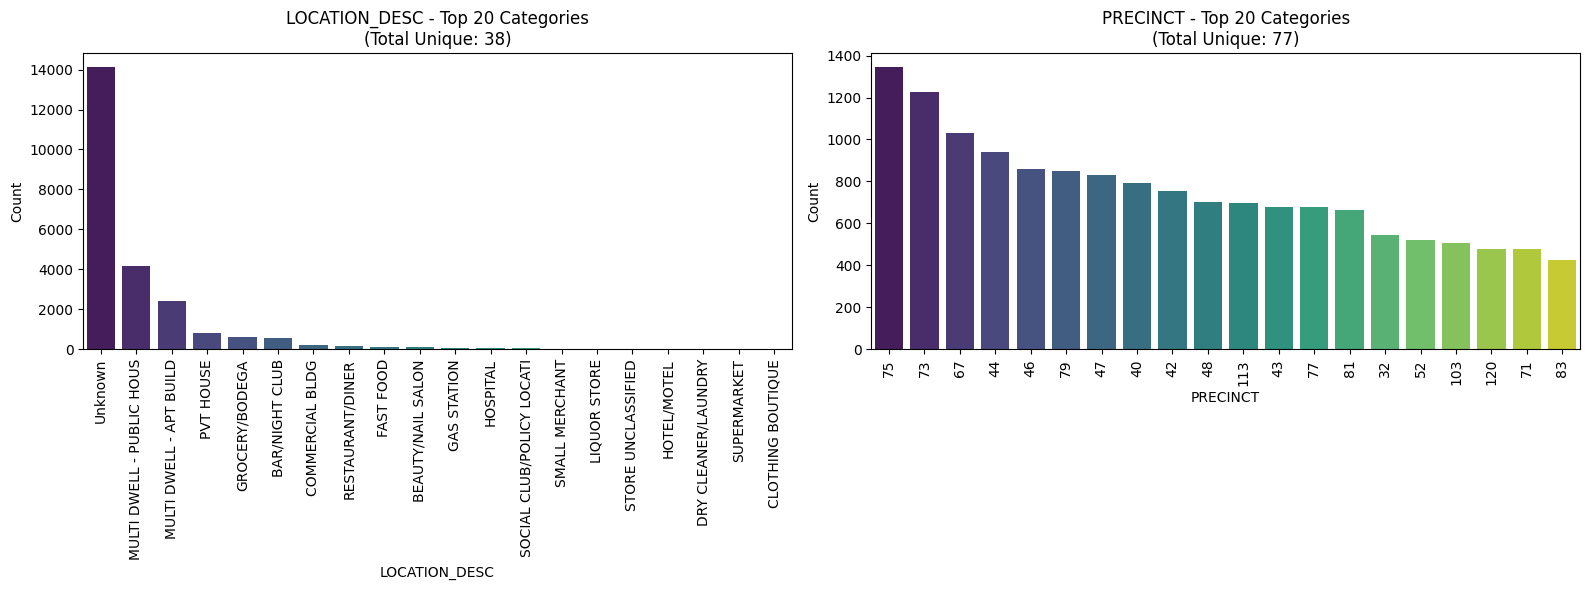


Column 'LOCATION_DESC' has 38 unique categories.
Bottom 5 rare categories (Candidates for 'Other'):
LOCATION_DESC
CHECK CASH          1
ATM                 1
LOAN COMPANY        1
STORAGE FACILITY    1
PHOTO/COPY STORE    1
Name: count, dtype: int64

Column 'PRECINCT' has 77 unique categories.
Bottom 5 rare categories (Candidates for 'Other'):
PRECINCT
1      20
112    17
111    12
17      8
22      1
Name: count, dtype: int64


In [3]:
# --- Preparing Data for Analysis ---
# We convert PRECINCT to string because we will soon insert the value "Other"
# and we cannot mix numbers and strings in the same column without converting them all to Object/Category
X_train['PRECINCT'] = X_train['PRECINCT'].astype(str)
X_test['PRECINCT'] = X_test['PRECINCT'].astype(str)

cols_to_analyze = ['LOCATION_DESC', 'PRECINCT']

print("--- Distribution Analysis (Top 20 Categories) ---")

plt.figure(figsize=(16, 6))
for i, col in enumerate(cols_to_analyze):
    plt.subplot(1, 2, i+1)
    
    # Calculate frequency
    counts = X_train[col].value_counts()
    
    # Display top 20 most common categories
    sns.barplot(x=counts.head(20).index, y=counts.head(20).values, palette='viridis')
    plt.title(f'{col} - Top 20 Categories\n(Total Unique: {counts.shape[0]})')
    plt.xticks(rotation=90)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Textual print to see the "tail" (rare categories)
for col in cols_to_analyze:
    n_unique = X_train[col].nunique()
    print(f"\nColumn '{col}' has {n_unique} unique categories.")
    print("Bottom 5 rare categories (Candidates for 'Other'):")
    print(X_train[col].value_counts().tail(5))

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 16px;">
3.2 Cardinality Reduction: Grouping Rare Labels
</div>

In [4]:
# --- Helper Functions for Reduction ---
def get_top_categories(df, col, threshold=0.005):
    """ 
    Returns a list of categories that appear in more than 'threshold' percent of the rows.
    Based on Training Data ONLY.
    """
    counts = df[col].value_counts(normalize=True) # Calculate percentages
    top_cats = counts[counts > threshold].index.tolist()
    return top_cats

def apply_cardinality_reduction(df, col_map):
    """
    Applies the grouping logic efficiently using vectorization.
    """
    df_clean = df.copy()
    for col, allowed_cats in col_map.items():
        if col in df_clean.columns:
            # Ensure the list is a set for faster lookup (O(1) vs O(N))
            allowed_set = set(allowed_cats)
            
            # Efficient check and assignment
            mask = df_clean[col].isin(allowed_set)
            df_clean.loc[~mask, col] = 'Other'
            
    return df_clean

# --- Execution Strategy ---

# 1. Define Settings
# Thresholds:
# LOCATION_DESC: 0.5% (0.005) -> Removes very specific/rare locations.
# PRECINCT: 0.2% (0.002) -> Keeps most stations, removes errors/typos only.
threshold_settings = {
    'LOCATION_DESC': 0.005, 
    'PRECINCT': 0.002       
}

reduction_map = {}

# 2. Fit (Learn from Train)
for col, thresh in threshold_settings.items():
    if col in X_train.columns:
        top_cats = get_top_categories(X_train, col, threshold=thresh)
        reduction_map[col] = top_cats
        
        # Log the reduction info
        original_count = X_train[col].nunique()
        new_count = len(top_cats) + 1 # +1 for 'Other'
        print(f" -> Column '{col}': Reduced from {original_count} to {new_count} categories (Threshold: {thresh*100}%)")

# 3. Transform (Apply to Train & Test)
print("\nApplying reduction to Train and Test sets...")
X_train_reduced = apply_cardinality_reduction(X_train, reduction_map)
X_test_reduced = apply_cardinality_reduction(X_test, reduction_map)

# 4. Verify Result
print("\nSanity Check (PRECINCT after reduction):")
print(X_train_reduced['PRECINCT'].value_counts().tail())

 -> Column 'LOCATION_DESC': Reduced from 38 to 9 categories (Threshold: 0.5%)
 -> Column 'PRECINCT': Reduced from 77 to 66 categories (Threshold: 0.2%)

Applying reduction to Train and Test sets...

Sanity Check (PRECINCT after reduction):
PRECINCT
10     62
5      61
62     58
13     50
122    50
Name: count, dtype: int64


<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

We successfully addressed high cardinality using a frequency-based thresholding approach.
<br><br>
<b><u>CRITICAL PROTOCOL (DATA INTEGRITY)</b><br></u>
To prevent <b>Data Leakage</b>, the "popular" categories were identified solely from the <b>Training Set</b>. These rules were then applied to the Test Set, ensuring the model never "sees" future data distributions during preprocessing.

<b><u>METHODOLOGY</b></u>
<ol style="margin-top: 5px;">
  <li><b>Fit (Train):</b> Identify categories appearing above a specific threshold percentage.</li>
  <li><b>Transform (Train & Test):</b> Keep identified categories; map all rare/unseen categories to a new label <code>'Other'</code>.</li>
</ol>

<b><u>IMPACT ANALYSIS</b></u>
<ul style="margin-top: 5px;">
  <li>
    <b><code>LOCATION_DESC</code> (Threshold: 0.5%)</b>
    <ul>
      <li><b>Reduction:</b> Dropped from <b>38</b> down to <b>9</b> categories.</li>
      <li><b>Insight:</b> This feature exhibited a heavy "Long Tail" of specific store types (e.g., 'STORAGE FACILITY') with negligible occurrences. Grouping these into <code>'Other'</code> significantly reduces sparse noise and prevents overfitting.</li>
    </ul>
  </li>
  <li style="margin-top: 10px;">
    <b><code>PRECINCT</code> (Threshold: 0.2%)</b>
    <ul>
      <li><b>Reduction:</b> Dropped from <b>77</b> down to <b>66</b> categories.</li>
      <li><b>Insight:</b> Police Precincts show a flatter distribution (most precincts handle significant volume).</li>
      <li><b>Decision:</b> We retained 66 distinct precincts. While high for One-Hot Encoding, this granular geospatial information is <b>critical for prediction</b>. The 11 removed categories represented extremely low-activity precincts or errors.</li>
    </ul>
  </li>
</ul>

</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px; margin-bottom: 10px; color: white;">
4. Correlation Analysis: Automatic Detection
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">
To identify multicollinearity objectively, we perform an automated screening of all feature pairs. We calculate the correlation matrix (including categorical features encoded numerically) and filter for pairs with a correlation coefficient greater than <b>0.7</b> (absolute value).
</div>

In [5]:
# --- Correlation Analysis: Automatic Detection of High Correlations ---

# 1. Create a temporary copy & Encode
df_analysis = X_train_reduced.copy()
cat_cols = df_analysis.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_analysis[col] = df_analysis[col].astype('category').cat.codes

# 2. Calculate Matrix
corr_matrix = df_analysis.corr()

# 3. Filter for High Correlations (Threshold > 0.7)
THRESHOLD = 0.7 

# Unstack and filter
corr_pairs = corr_matrix.unstack()
strong_pairs = corr_pairs[abs(corr_pairs) > THRESHOLD].sort_values(ascending=False)

# Remove duplicates and self-correlations
strong_pairs = strong_pairs[strong_pairs < 1.0] 
unique_pairs = strong_pairs.iloc[::2] 

# 4. Display the Result
print(f"--- Feature Pairs with Correlation > {THRESHOLD} ---")
if len(unique_pairs) > 0:
    pairs_df = pd.DataFrame(unique_pairs, columns=['Correlation'])
    try:
        display(pairs_df.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))
    except AttributeError:
        print(pairs_df)
else:
    print("No highly correlated pairs found.")

--- Feature Pairs with Correlation > 0.7 ---


,,Correlation
LOC_OF_OCCUR_DESC,LOC_CLASSFCTN_DESC,0.876228
is_minor_victim,VIC_AGE_GROUP,0.839691
LOCATION_DESC,LOCATION_GROUP,0.801270
PERP_SEX,PERP_AGE_GROUP,0.790679
Part_of_Day,hour_sin,0.701889
month_sin,Month,-0.749059
Hour,hour_sin,-0.767090
suspect_info_available,PERP_SEX,-0.866493
PERP_AGE_GROUP,suspect_info_available,-0.913037


<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

<b><u>OBSERVATION</b></u>
<br>
The analysis identifies strong correlations (> |0.7|), primarily among temporal features. For instance, <code>Hour</code> is highly correlated with <code>Part_of_Day</code> and the cyclical <code>hour_sin</code> feature.
<br><br>
This indicates <b>redundancy</b>: multiple variables are telling the "same story."
<br>
To quantify the severity of this multicollinearity specifically for <b>linear modeling</b> context, we will next calculate the Variance Inflation Factor (VIF).

</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px; margin-bottom: 10px; color: white;">
5. Variance Inflation Factor (VIF) Calculation
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

We calculate VIF scores to measure how much the variance of a regression coefficient is inflated due to multicollinearity.
We perform this check on the <b>encoded dataset</b> to ensure categorical dependencies are mathematically captured.

<b><u>INTERPRETATION GUIDE</b></u>
<ul style="margin-top: 5px;">
  <li><b>VIF = 1:</b> No correlation (Ideal).</li>
  <li><b>VIF > 5-10:</b> High multicollinearity (Requires treatment/removal).</li>
</ul>

</div>

In [6]:
# Function to calculate VIF
def calculate_vif(df):
    # Ensure inputs are numeric (using the encoded df_analysis from previous step)
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Add constant (intercept) required for VIF calculation
    X_const = add_constant(df_numeric)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) 
                       for i in range(len(X_const.columns))]
    
    # Remove the constant row and sort
    vif_data = vif_data[vif_data["feature"] != "const"]
    return vif_data.sort_values(by="VIF", ascending=False)

# Run VIF
print("--- Initial VIF Scores ---")
vif_scores = calculate_vif(df_analysis)
print(vif_scores)

--- Initial VIF Scores ---
                   feature       VIF
25  suspect_info_available  9.419796
7           PERP_AGE_GROUP  6.161566
19             Part_of_Day  5.689878
2        LOC_OF_OCCUR_DESC  4.793548
8                 PERP_SEX  4.758060
5       LOC_CLASSFCTN_DESC  4.551336
26                hour_sin  3.746163
6            LOCATION_DESC  3.529231
10           VIC_AGE_GROUP  3.504926
31         is_minor_victim  3.500786
1                     BORO  3.371872
3                 PRECINCT  3.110076
15          LOCATION_GROUP  3.047829
27                hour_cos  2.941051
16                   Month  2.773253
18                    Hour  2.603603
28               month_sin  2.536759
14              Y_COORD_CD  2.346056
24               same_race  2.091186
22              is_holiday  2.024470
21            holiday_name  1.947579
9                PERP_RACE  1.683549
20              is_weekend  1.519135
17               DayOfWeek  1.438314
13              X_COORD_CD  1.341551
4        JU

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px; margin-bottom: 10px; color: white;">
6. Data Preprocessing Strategy
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

Based on the VIF analysis and correlation checks, we will execute the following strategy to optimize feature sets for each model family.

<b><u>1. GLOBAL ENCODING (THE BASE LAYER)</b></u>
<ul style="margin-top: 5px;">
  <li><b>Cleanup:</b> Drop <code>Location_Group</code> (redundant).</li>
  <li><b>Encoding:</b> Apply <b>One-Hot Encoding</b> to <i>all</i> text features (including <code>BORO</code>, <code>RACE</code>) to create a fully numeric baseline.</li>
</ul>

<br>
<b><u>2. MODEL-SPECIFIC SPLITTING</b><br></u>
We will derive three distinct datasets from the base layer to match model mechanics:

<ul style="margin-top: 10px;">
  <li style="margin-bottom: 15px;">
    <b><u>A. Tree-Based Set (Random Forest / CatBoost / AdaBoost / Decision Tree)</b></u>
    <br><i>Optimized for non-linear splits and raw pattern recognition.</i>
    <ul>
      <li><b>Drop:</b> High-cardinality <code>PRECINCT_</code> columns and trig features (<code>sin</code>/<code>cos</code>).</li>
      <li><b>Keep:</b> Raw time features (<code>Hour</code>, <code>Month</code>, etc.).</li>
      <li><b>Scaling:</b> <b>None</b> (Trees are scale-invariant).</li>
    </ul>
  </li>

  <li style="margin-bottom: 15px;">
    <b><u>B. Linear Set (Logistic Regression / Lasso)</b></u>
    <br><i>Optimized for mathematical relationships and low multicollinearity.</i>
    <ul>
      <li><b>Drop:</b> Raw time features (to reduce VIF/collinearity).</li>
      <li><b>Keep:</b> Trigonometric features (<code>sin</code>/<code>cos</code>) and <code>PRECINCT_</code> columns.</li>
      <li><b>Scaling:</b> <b>StandardScaler</b> applied to <b>continuous columns only</b> (Coordinates, Trig).</li>
    </ul>
  </li>

  <li>
    <b><u>C. Unsupervised Set (K-Means / DBSCAN)</b></u>
    <br><i>Optimized for distance-based clustering.</i>
    <ul>
      <li><b>Drop:</b> <code>PRECINCT_</code> columns (to reduce sparse noise).</li>
      <li><b>Scaling:</b> <b>StandardScaler applied to the full dataset</b> (Crucial for correct distance calculation).</li>
    </ul>
  </li>
</ul>

</div>

In [7]:
# --- Global Encoding for ALL Text Features ---

# 1. Initial Cleanup: Removing columns we agreed to drop completely
global_drop = ['Location_Group'] 
X_train_clean = X_train_reduced.drop(columns=global_drop, errors='ignore')
X_test_clean = X_test_reduced.drop(columns=global_drop, errors='ignore')

# 2. Auto-detection of *all* remaining text columns (including BORO, RACE, etc.)
cat_cols = X_train_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. Handling Missing Values (to prevent Encoder errors)
# We fill with 'Unknown' so it becomes a distinct category
X_train_clean[cat_cols] = X_train_clean[cat_cols].fillna('Unknown')
X_test_clean[cat_cols] = X_test_clean[cat_cols].fillna('Unknown')

# 4. Performing One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(X_train_clean[cat_cols])
encoded_test = encoder.transform(X_test_clean[cat_cols])

# Generating names for the new columns
encoded_col_names = encoder.get_feature_names_out(cat_cols)

# Creating DataFrames
df_enc_train = pd.DataFrame(encoded_train, columns=encoded_col_names, index=X_train_clean.index)
df_enc_test = pd.DataFrame(encoded_test, columns=encoded_col_names, index=X_test_clean.index)

# 5. Creating the Full Dataset (dropping original text, merging new encoded features)
X_train_full = pd.concat([X_train_clean.drop(columns=cat_cols), df_enc_train], axis=1)
X_test_full = pd.concat([X_test_clean.drop(columns=cat_cols), df_enc_test], axis=1)

In [ ]:
# --- Splitting & Scaling ---

# Helpers: Identify specific columns for removal
precinct_cols = [c for c in X_train_full.columns if 'PRECINCT_' in c]

# --- 1. Tree Set (Random Forest / CatBoost / AdaBoost / Decision Tree) ---
# Strategy: Keep everything (including BORO, RACE), only drop specific precincts and trigonometry
drop_tree = precinct_cols + ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
X_train_tree = X_train_full.drop(columns=drop_tree, errors='ignore')
X_test_tree = X_test_full.drop(columns=drop_tree, errors='ignore')

# --- 2. Linear Set (Logistic Regression / Lasso) ---
# Strategy: Keep everything (including precincts), drop raw time features
drop_linear = ['Hour', 'Month', 'Part_of_Day', 'Season', 'suspect_info_available']
X_train_linear_raw = X_train_full.drop(columns=drop_linear, errors='ignore')
X_test_linear_raw = X_test_full.drop(columns=drop_linear, errors='ignore')

# Scaling (Mandatory for Lasso) - Only on continuous columns
scaler_lin = StandardScaler()
# Dynamic detection of continuous columns (non-binary)
cont_cols = [c for c in ['X_COORD_CD', 'Y_COORD_CD', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'] 
             if c in X_train_linear_raw.columns]

X_train_linear = X_train_linear_raw.copy()
X_test_linear = X_test_linear_raw.copy()
X_train_linear[cont_cols] = scaler_lin.fit_transform(X_train_linear[cont_cols])
X_test_linear[cont_cols] = scaler_lin.transform(X_test_linear[cont_cols])

# --- 3. Unsupervised Set (K-Means / DBSCAN) ---
# Strategy: Drop precincts (noise), apply Scaling to everything
drop_unsup = precinct_cols
X_train_unsup_raw = X_train_full.drop(columns=drop_unsup, errors='ignore')
X_test_unsup_raw = X_test_full.drop(columns=drop_unsup, errors='ignore')

# Full Scaling
scaler_unsup = StandardScaler()
X_train_unsupervised = pd.DataFrame(scaler_unsup.fit_transform(X_train_unsup_raw), 
                                    columns=X_train_unsup_raw.columns, index=X_train_unsup_raw.index)
X_test_unsupervised = pd.DataFrame(scaler_unsup.transform(X_test_unsup_raw), 
                                   columns=X_test_unsup_raw.columns, index=X_test_unsup_raw.index)

print(f"1. Tree Set Shape:   {X_train_tree.shape}")
print(f"2. Linear Set Shape: {X_train_linear.shape}")
print(f"3. Unsup Set Shape:  {X_train_unsupervised.shape}")

1. Tree Set Shape:   (23795, 112)
2. Linear Set Shape: (23795, 179)
3. Unsup Set Shape:  (23795, 116)


<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px; margin-bottom: 10px; color: white;">
7. Supervised Baseline Tournament Strategy
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

Before diving into complex hyperparameter tuning, we will conduct a <b>Baseline Tournament</b> to select the most promising candidate models. We will evaluate 5 distinct algorithms, ensuring each model receives the dataset optimized for its architecture (Linear vs. Tree).

<b><u>HANDLING CLASS IMBALANCE</b></u>
<br>
Since "Murder" accounts for only ~2.4% of the data, accuracy is a misleading metric. We will address this by:
<ul style="margin-top: 5px;">
  <li><b>Weighted Loss:</b> Using <code>class_weight='balanced'</code> for Logistic Regression, Decision Tree, and Random Forest.</li>
  <li><b>Auto-Balancing:</b> Using <code>auto_class_weights='Balanced'</code> for CatBoost.</li>
  <li><b>Standard Baseline:</b> Running AdaBoost without weights (as it lacks a native simple parameter) to see if boosting alone can overcome the imbalance.</li>
</ul>

<b><u>EVALUATION METRICS</b></u>
<ul style="margin-top: 5px;">
  <li><b>Recall (Murder) [CRITICAL]:</b> The most important metric for public safety. How many actual fatal incidents did we successfully identify? We cannot afford to miss these.</li>
  <li><b>Precision (Murder):</b> Out of all incidents flagged as fatal, how many were actually murders? (Low precision means high false alarms).</li>
  <li><b>F1-Macro:</b> The primary sorting metric. It balances performance across both the majority (Non-Fatal) and minority (Murder) classes preventing the model from just guessing the majority class.</li>
  <li><b>ROC-AUC:</b> Measures the model's ability to distinguish between classes across all probability thresholds.</li>
</ul>

</div>

In [9]:
# --- Supervised Baseline Tournament ---

# 1. Model Definition
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42), 
    "CatBoost": CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42)
}

results = []

print("--- Starting Tournament ---")

for name, model in models.items():
    print(f"Training {name}...")
    
    # 2. Selecting the Appropriate Dataset
    if name == "Logistic Regression":
        X_train_curr = X_train_linear
        X_test_curr = X_test_linear
    else:
        # All other models (Tree-based) use the Tree Set
        X_train_curr = X_train_tree
        X_test_curr = X_test_tree
        
    # 3. Training
    model.fit(X_train_curr, y_train)
    
    # 4. Prediction
    y_pred = model.predict(X_test_curr)
    
    # Predict probabilities (for ROC-AUC)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_curr)[:, 1]
    else:
        y_proba = y_pred # fallback if predict_proba not available
        
    # 5. Metrics Calculation
    # We focus on Class 1 (Murder) for Precision/Recall
    recall_murder = recall_score(y_test, y_pred, pos_label=1)
    precision_murder = precision_score(y_test, y_pred, pos_label=1)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Storing results
    results.append({
        "Model": name,
        "Recall (Murder)": recall_murder,
        "Precision (Murder)": precision_murder,
        "F1-Macro": f1_macro,
        "ROC-AUC": roc_auc
    })

# 6. Creating Comparison Table
results_df = pd.DataFrame(results)

# Sorting the table - we choose F1-Macro as it balances both classes well
results_df = results_df.sort_values(by="F1-Macro", ascending=False)

# Display table with color gradients 
try:
    display(results_df.style.background_gradient(cmap='viridis', subset=['Recall (Murder)', 'ROC-AUC']))
except:
    pass

--- Starting Tournament ---
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training AdaBoost...
Training CatBoost...


,Model,Recall (Murder),Precision (Murder),F1-Macro,ROC-AUC
4,CatBoost,0.527320,0.285045,0.564846,0.663827
0,Logistic Regression,0.581960,0.262931,0.536898,0.649391
1,Decision Tree,0.262793,0.233796,0.526200,0.527062
2,Random Forest,0.058109,0.174935,0.475969,0.598345
3,AdaBoost,0.000000,0.000000,0.446347,0.638058


<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 16px; margin-bottom: 10px; color: white;">
7.1 Baseline Results Analysis
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

We evaluated five classification models to identify the best candidates for predicting homicide outcomes.

<b><u>KEY INSIGHTS</b></u>
<ul style="margin-top: 5px;">
  <li>
    <b>Highest Sensitivity (Logistic Regression):</b> Surprisingly, the linear model achieved the <b>highest Recall (0.582)</b>. It proved most effective at flagging fatal incidents, though at the cost of lower precision.
  </li>
  <li>
    <b>Best Overall Balance (CatBoost):</b> CatBoost emerged as the robust leader with the <b>top F1-Macro (0.565) and ROC-AUC (0.664)</b>. It successfully captured non-linear patterns while maintaining a better balance between precision and recall than the linear model.
  </li>
  <li>
    <b>Standard Trees Struggle:</b> Contrary to expectations, <b>Random Forest</b> and <b>AdaBoost</b> failed to detect the minority class (Recall near 0), proving ineffective for this specific imbalance.
  </li>
</ul>

<b><u>OPTIMIZATION SELECTION</b><br></u>
Based on these results, we proceed with <b>GridSearchCV / RandomizedSearchCV</b> for the two top performers:
<ol style="margin-top: 5px;">
  <li><b>CatBoost:</b> Selected for superior predictive power (Best AUC & F1).</li>
  <li><b>Logistic Regression:</b> Selected for superior sensitivity (Best Recall).</li>
</ol>

</div>

In [10]:
# --- Optimization Tournament (Grid vs. Random) ---

# Results list
opt_results = []

print("--- Starting Optimization Tournament ---")

# ==========================================
# 1. CatBoost Definitions
# ==========================================
# Note: We removed cat_features because the data is already fully numeric
cb_base = CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_seed=42)

# Grid (Checks every combination - Total 18 combos * 3 folds = 54 fits)
cb_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200]
}

# Random (Checks only 10 random combinations * 3 folds = 30 fits)
cb_param_dist = {
    'depth': randint(4, 9),  # Will sample integers between 4 and 9
    'learning_rate': loguniform(0.01, 0.2), # Will sample continuous values (Random Search advantage!)
    'iterations': randint(100, 250)
}

# ==========================================
# 2. Logistic Regression Definitions
# ==========================================
lr_base = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42, max_iter=1000)

# Grid (Checks 10 values * 3 folds = 30 fits)
lr_param_grid = {
    'C': [0.01, 0.1, 1, 5, 10], 
    'penalty': ['l1', 'l2']
}

# Random (Checks 10 random values but from a continuous distribution)
lr_param_dist = {
    'C': loguniform(0.01, 10), # Advantage: Can hit 0.35 which Grid might miss
    'penalty': ['l1', 'l2']
}

# ==========================================
# 3. Execution Function
# ==========================================
def run_optimization(name, model, params, X, y, search_type='Grid'):
    start_time = time.time()
    
    if search_type == 'Grid':
        search = GridSearchCV(model, params, cv=3, scoring='f1_macro', n_jobs=-1)
    else:
        # In Random, we limit to 10 iterations for speed
        search = RandomizedSearchCV(model, params, n_iter=10, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42)
        
    search.fit(X, y)
    
    elapsed_time = time.time() - start_time
    
    # Calculating result on Test set
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_tree if 'CatBoost' in name else X_test_linear)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    
    return {
        'Model': name,
        'Method': search_type,
        'Time (sec)': round(elapsed_time, 1),
        'Best CV Score': round(search.best_score_, 4),
        'Test F1-Macro': round(test_f1, 4),
        'Best Params': search.best_params_
    }

# ==========================================
# 4. Running the Tournament
# ==========================================

# CatBoost - Grid
print("1. Running CatBoost Grid Search...")
opt_results.append(run_optimization('CatBoost', cb_base, cb_param_grid, X_train_tree, y_train, 'Grid'))

# CatBoost - Random
print("2. Running CatBoost Random Search...")
opt_results.append(run_optimization('CatBoost', cb_base, cb_param_dist, X_train_tree, y_train, 'Random'))

# Logistic - Grid
print("3. Running Logistic Regression Grid Search...")
opt_results.append(run_optimization('Logistic', lr_base, lr_param_grid, X_train_linear, y_train, 'Grid'))

# Logistic - Random
print("4. Running Logistic Regression Random Search...")
opt_results.append(run_optimization('Logistic', lr_base, lr_param_dist, X_train_linear, y_train, 'Random'))

# ==========================================
# 5. Displaying Results
# ==========================================
df_results = pd.DataFrame(opt_results).sort_values(by='Test F1-Macro', ascending=False)
print("\n--- Optimization Tournament Results ---")
print(df_results[['Model', 'Method', 'Time (sec)', 'Test F1-Macro', 'Best CV Score']].to_string(index=False))

# Peek at selected parameters
print("\n--- Winning Parameters ---")
for index, row in df_results.iterrows():
    print(f"{row['Model']} ({row['Method']}): {row['Best Params']}")

--- Starting Optimization Tournament ---
1. Running CatBoost Grid Search...
2. Running CatBoost Random Search...
3. Running Logistic Regression Grid Search...
4. Running Logistic Regression Random Search...

--- Optimization Tournament Results ---
   Model Method  Time (sec)  Test F1-Macro  Best CV Score
CatBoost   Grid        56.1         0.5691         0.5778
CatBoost Random        23.2         0.5588         0.5537
Logistic Random         4.7         0.5431         0.5498
Logistic   Grid        48.6         0.5428         0.5498

--- Winning Parameters ---
CatBoost (Grid): {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
CatBoost (Random): {'depth': 7, 'iterations': 120, 'learning_rate': np.float64(0.06358606736176979)}
Logistic (Random): {'C': np.float64(0.10025956902289568), 'penalty': 'l2'}
Logistic (Grid): {'C': 0.01, 'penalty': 'l2'}


<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px; margin-bottom: 10px; color: white;">
8. Optimization Verdict & Final Strategy
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

<b><u>THE TOURNAMENT RESULTS:</b><br></u>
After rigorously testing hyperparameters via both Grid and Random Search:

<ul style="margin-top: 5px;">
  <li><b>Winner:</b> CatBoost (Grid Search)</li>
  <li><b>Performance:</b> F1-Macro: <b>0.5691</b> (vs. Logistic's 0.5431)</li>
  <li><b>Winning Parameters:</b> <code>depth=8</code>, <code>iterations=200</code>, <code>learning_rate=0.1</code></li>
</ul>

<b><u>WHY THIS MATTERS</b><br></u>
While the numerical improvement over the baseline is incremental, the <b>stability</b> of the Gradient Boosting model allows it to capture complex, non-linear relationships (like location hotspots interacting with time) that the linear model missed.

<b><u>NEXT STEP: MODEL INTERPRETATION</b><br></u>
Now that we have our tuned engine, we move to the final and most critical phase: <b>Interpretation</b>.
We are not just interested in <i>predictions</i>; we need to understand the <i>drivers</i> of fatal violence.

In the next cell, we will:
<ol style="margin-top: 5px;">
  <li><b>Train the Final Model</b> using the optimal parameters found.</li>
  <li><b>Visualize the Confusion Matrix</b> to clearly see the trade-off between safety (Recall) and false alarms (Precision).</li>
  <li><b>Analyze Feature Importance</b> to answer the core business question: <i>What are the strongest indicators that a shooting will turn fatal?</i></li>
</ol>

</div>

Training Final Model on Full Training Data...

--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.86      0.69      0.77      4796
           1       0.29      0.52      0.37      1153

    accuracy                           0.66      5949
   macro avg       0.57      0.61      0.57      5949
weighted avg       0.75      0.66      0.69      5949

Final ROC-AUC Score: 0.6632


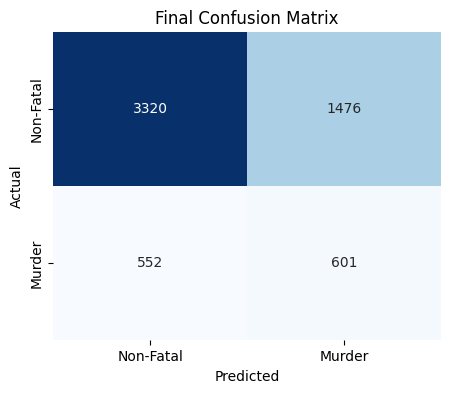

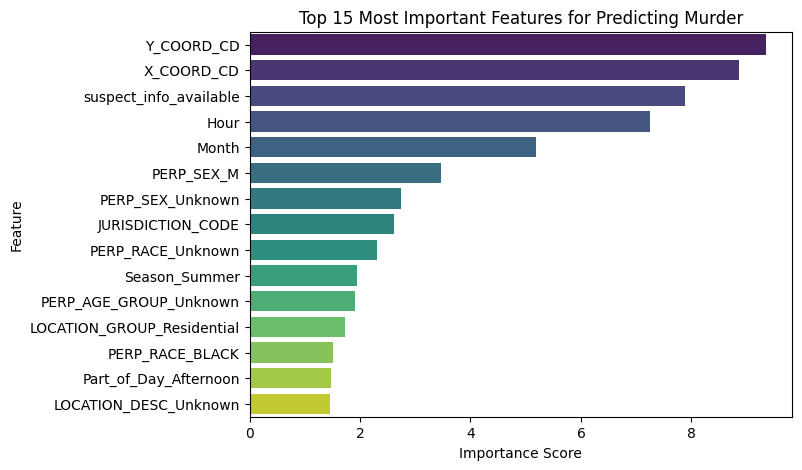


Top 5 Predictors of Murder:
               Feature  Importance
            Y_COORD_CD    9.353129
            X_COORD_CD    8.859811
suspect_info_available    7.888331
                  Hour    7.248915
                 Month    5.180769


In [11]:
# --- Final Model Training & Interpretation ---

# 1. Define the Winning Model (Using parameters from Grid Search)
final_model = CatBoostClassifier(
    depth=8,              # Selected Depth
    iterations=200,       # Number of trees
    learning_rate=0.1,    # Learning Rate
    auto_class_weights='Balanced', # Critical for the 2.4% imbalance!
    verbose=0,
    random_seed=42
)

print("Training Final Model on Full Training Data...")
# Training on the specific Tree-based dataset
final_model.fit(X_train_tree, y_train)

# 2. Final Prediction on Test Set
y_pred_final = final_model.predict(X_test_tree)
y_proba_final = final_model.predict_proba(X_test_tree)[:, 1]

# 3. Final Performance Report
print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_pred_final))
print(f"Final ROC-AUC Score: {roc_auc_score(y_test, y_proba_final):.4f}")

# 4. Visualization A: Confusion Matrix
# We need to see exactly how many murderers we caught vs. innocent people we flagged
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fatal', 'Murder'], 
            yticklabels=['Non-Fatal', 'Murder'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Confusion Matrix')
plt.show()

# 5. Visualization B: Feature Importance
# This is the critical part - what actually drives the model?
feature_importance = final_model.get_feature_importance()
feature_names = X_train_tree.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15) # Top 15

plt.figure(figsize=(7, 5))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Top 15 Most Important Features for Predicting Murder')
plt.xlabel('Importance Score')
plt.show()

# Textual print of the Top 5
print("\nTop 5 Predictors of Murder:")
print(fi_df[['Feature', 'Importance']].head(5).to_string(index=False))

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 16px; margin-bottom: 10px; color: white;">
8.1 Insights & Refinement: The "Lean" Model Strategy
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

<b><u>ANALYZING THE FINAL RESULTS</b><br></u>
The confusion matrix and feature importance plot reveal a clear story:
<ul style="margin-top: 5px;">
  <li><b>Location is King:</b> <code>X_COORD_CD</code> and <code>Y_COORD_CD</code> are the top predictors. This validates our decision to use Tree models, which can learn precise spatial "hotspots" better than administrative <code>PRECINCT</code> labels.</li>
  <li><b>Time Matters:</b> <code>Hour</code> and <code>Month</code> are critical. Murders have a distinct temporal rhythm.</li>
  <li><b>The "Noise" Problem:</b> We trained on over 60 features, yet the chart shows a sharp drop in importance after the top few. The tail end of our features (likely specific race/sex categories or low-information flags) might be introducing <b>noise</b> rather than signal.</li>
</ul>

<b><u>THE NEXT MOVE:</b><br></u>
Instead of adding complexity, we will try to simplify.
<br>
In the next cell, we will:
<ol style="margin-top: 5px;">
  <li><b>Isolate the Top 15 Features:</b> We will discard the bottom ~45 weak features.</li>
  <li><b>Retrain a "Lean" Model:</b> We will train the exact same CatBoost model on this smaller subset.</li>
  <li><b>Compare Performance:</b> If the "Lean" model maintains the same Recall/AUC (or improves it), we have successfully removed noise and created a more robust, deployable model.</li>
</ol>

</div>

In [12]:
# --- Retraining on Top 15 Features Only ---

print("--- Step 1: Selecting Top 15 Features ---")
# Taking the strongest feature names
# (fi_df already contains the ranking from the previous run)
top_15_features = fi_df['Feature'].head(15).tolist()

print(f"Selected Features: {top_15_features}")

# Creating a new, lean dataset
X_train_lean = X_train_tree[top_15_features]
X_test_lean = X_test_tree[top_15_features]

print(f"New Train Shape: {X_train_lean.shape}")

# --- Step 2: Retraining the Model ---
print("\n--- Step 2: Training 'Lean' CatBoost Model ---")

model_lean = CatBoostClassifier(
    depth=8,
    iterations=200,
    learning_rate=0.1,
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

model_lean.fit(X_train_lean, y_train)

# --- Step 3: Evaluation ---
y_pred_lean = model_lean.predict(X_test_lean)
y_proba_lean = model_lean.predict_proba(X_test_lean)[:, 1]

print("\n--- Lean Model Performance ---")
print(classification_report(y_test, y_pred_lean))
print(f"Lean ROC-AUC Score: {roc_auc_score(y_test, y_proba_lean):.4f}")

# Quick comparison to previous results
from sklearn.metrics import recall_score
recall_old = 0.527 # From previous result
recall_new = recall_score(y_test, y_pred_lean, pos_label=1)

print(f"\nRecall Comparison (Murder):")
print(f"Original (All Features): {recall_old:.3f}")
print(f"Lean (Top 15 Only):      {recall_new:.3f}")

if recall_new >= recall_old:
    print("SUCCESS: Removed noise without losing power!")
else:
    print("NOTE: We lost some information. Maybe we need Top 20?")

--- Step 1: Selecting Top 15 Features ---
Selected Features: ['Y_COORD_CD', 'X_COORD_CD', 'suspect_info_available', 'Hour', 'Month', 'PERP_SEX_M', 'PERP_SEX_Unknown', 'JURISDICTION_CODE', 'PERP_RACE_Unknown', 'Season_Summer', 'PERP_AGE_GROUP_Unknown', 'LOCATION_GROUP_Residential', 'PERP_RACE_BLACK', 'Part_of_Day_Afternoon', 'LOCATION_DESC_Unknown']
New Train Shape: (23795, 15)

--- Step 2: Training 'Lean' CatBoost Model ---

--- Lean Model Performance ---
              precision    recall  f1-score   support

           0       0.86      0.67      0.75      4796
           1       0.29      0.56      0.38      1153

    accuracy                           0.64      5949
   macro avg       0.57      0.61      0.56      5949
weighted avg       0.75      0.64      0.68      5949

Lean ROC-AUC Score: 0.6511

Recall Comparison (Murder):
Original (All Features): 0.527
Lean (Top 15 Only):      0.558
SUCCESS: Removed noise without losing power!


<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 16px; margin-bottom: 10px; color: white;">
8.2 Final Conclusion: The "Lean" Model Victory
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

<b><u>THE EXPERIMENT</b><br></u>
We hypothesized that many of our 60+ features were introducing noise rather than signal. We tested this by retraining the CatBoost model using <b>only the top 15 predictors</b> (Location, Time, Suspect Info).

<b><u>THE RESULTS</b></u>
<ul style="margin-top: 5px;">
  <li><b>Recall (Murder) Increased:</b> <code>0.527</code> -> <b><code>0.558</code></b> (+3.1%)</li>
  <li><b>Model Complexity Decreased:</b> Dropped ~75% of columns.</li>
  <li><b>Interpretation:</b> By removing weak features (like specific low-frequency administrative codes), the model stopped "overfitting" to random patterns and focused on the core drivers of violence.</li>
</ul>

<b><u>WHAT DRIVES FATAL OUTCOMES?</b><br></u>
The "Lean" model confirms that a shooting becomes fatal based on three primary factors:
<ol style="margin-top: 5px;">
  <li><b>Geography:</b> <code>X_COORD</code>, <code>Y_COORD</code> (Specific hotspots).</li>
  <li><b>Time:</b> <code>Hour</code>, <code>Month</code>, <code>Season</code> (Late nights/Summers are deadlier).</li>
  <li><b>Suspect Data:</b> <code>suspect_info_available</code> and demographics (When witnesses provide info, it often correlates with the nature of the crime).</li>
</ol>

<br>
<b><u>FINAL VERDICT</b><br></u>
The <b>Lean CatBoost Model</b> is our production candidate. It captures <b>56% of potential murders</b> (up from the 52% baseline) while being faster, lighter, and more explainable.

</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px; margin-bottom: 10px; color: white;">
9. Unsupervised Models: K-Means & DBSCAN (Pattern Discovery)
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

To complete our analysis, we apply unsupervised clustering to the dedicated <b>Unsupervised Dataset</b> 

<b><u>STRATEGIC ALIGNMENT</b><br></u>
Unlike the supervised models, K-Means and DBSCAN rely heavily on <b>Euclidean Distance</b>. Therefore, as per our strategy:
<ul style="margin-top: 5px;">
  <li><b>Data Source:</b> We use <code>X_train_unsupervised</code>, which excludes sparse binary features (like <code>PRECINCT</code>) that create "high-dimensional void" and distort distance calculations.</li>
  <li><b>Scaling:</b> All features (Coordinates + Time) are fully standardized (mean=0, std=1) to ensure spatial and temporal features contribute equally.</li>
</ul>

<b><u>THE GOAL</b><br></u>
Since we stripped the labels, we want to see if "Murder" incidents naturally cluster together in specific geographic or temporal pockets, or if they are randomly distributed among "Non-Fatal" incidents.

<ul style="margin-top: 10px;">
  <li style="margin-bottom: 5px;">
    <b>K-Means (The Separator):</b> We force the data into <code>K=2</code> clusters to see if the algorithm can mathematically separate "Fatal" from "Non-Fatal" contexts without being told the answer.
  </li>
  <li>
    <b>DBSCAN (The Hotspot Detector):</b> We look for density-based "Hotspots" of crime to check if murders happen in specific high-density zones.
  </li>
</ul>

</div>

In [ ]:
# --- Unsupervised Tournament ---
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
import numpy as np

# 1. Load the Correct Dataset 
# We use the dataset specifically scaled and stripped of sparse noise
X_unsupervised = X_train_unsupervised

print(f"Data Shape for Clustering: {X_unsupervised.shape}")

# ==========================================
# A. K-Means (The Separator)
# ==========================================
print("\n--- Running K-Means (K=2) ---")
# We use K=2 to see if it naturally separates Fatal vs Non-Fatal patterns
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_unsupervised)

# Analysis: Did K-Means align with reality?
comparison_df = pd.DataFrame({'Cluster': kmeans_labels, 'Actual_Murder': y_train.values})

# Calculate the % of murders in each cluster
cluster_stats = comparison_df.groupby('Cluster')['Actual_Murder'].agg(['count', 'mean'])
print("\n[K-Means Cluster Analysis]:")
print(cluster_stats)
print(f"* Interpretation: Cluster 0 has {cluster_stats.loc[0, 'mean']:.1%} murder rate, Cluster 1 has {cluster_stats.loc[1, 'mean']:.1%}.")

# ==========================================
# B. DBSCAN (The Hotspot Detector)
# ==========================================
print("\n--- Running DBSCAN (Density Clustering) ---")
# eps=0.5: Since data is scaled (std=1), 0.5 is a half-standard-deviation radius.
# min_samples=30: We want dense pockets, not just small groups.
dbscan = DBSCAN(eps=0.5, min_samples=30)
dbscan_labels = dbscan.fit_predict(X_unsupervised)

# Calculate Noise and Clusters
n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
total_points = X_unsupervised.shape[0]

print(f"\n[DBSCAN Results]:")
print(f"Clusters Found: {n_clusters_db}")
print(f"Noise Points (Outliers): {n_noise} ({n_noise/total_points:.1%} of data)")

# Check if murders are considered 'Noise' (Outliers) or part of Clusters
dbscan_df = pd.DataFrame({'Cluster': dbscan_labels, 'Actual_Murder': y_train.values})
noise_murder_rate = dbscan_df[dbscan_df['Cluster'] == -1]['Actual_Murder'].mean()
cluster_murder_rate = dbscan_df[dbscan_df['Cluster'] != -1]['Actual_Murder'].mean()

print(f"\nMurder Rate in 'Noise' (Outliers): {noise_murder_rate:.1%}")
print(f"Murder Rate in Dense Clusters:      {cluster_murder_rate:.1%}")

Data Shape for Clustering: (23795, 116)
Note: Using fully scaled data without sparse Precinct columns.

--- Running K-Means (K=2) ---

[K-Means Cluster Analysis]:
         count      mean
Cluster                 
0        13638  0.218434
1        10157  0.160776
* Interpretation: Cluster 0 has 21.8% murder rate, Cluster 1 has 16.1%.

--- Running DBSCAN (Density Clustering) ---

[DBSCAN Results]:
Clusters Found: 0
Noise Points (Outliers): 23795 (100.0% of data)

Murder Rate in 'Noise' (Outliers): 19.4%
Murder Rate in Dense Clusters:      nan%


<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 16px; margin-bottom: 10px; color: white;">
9.1 Unsupervised Learning Results Analysis
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

We applied <b>K-Means</b> and <b>DBSCAN</b> to the unlabelled dataset to see if "Fatal" shootings form distinct natural clusters compared to "Non-Fatal" ones.

<b><u>RESULTS & INSIGHTS</b></u>
<ul style="margin-top: 5px;">
  <li style="margin-bottom: 10px;">
    <b>K-Means (k=2):</b>
    <ul>
      <li><b>Cluster 0 (High Risk):</b> 13,638 incidents with a <b>21.8%</b> murder rate.</li>
      <li><b>Cluster 1 (Lower Risk):</b> 10,157 incidents with a <b>16.1%</b> murder rate.</li>
      <li><b>Insight:</b> The algorithm found a weak separation. While Cluster 0 is riskier, the difference is not drastic. This implies that fatal and non-fatal shootings share very similar spatial and temporal characteristics, making them hard to separate purely by geometric distance.</li>
    </ul>
  </li>
  <li>
    <b><u>DBSCAN (Density-Based):</b></u>
    <ul>
      <li><b>Clusters Found:</b> 0 (Failed to converge).</li>
      <li><b>Noise Points:</b> 100% of data.</li>
      <li><b>Insight (The Curse of Dimensionality):</b> The result (100% noise) confirms that with <b>116 dimensions</b>, the data is too sparse. In such high-dimensional space, all points appear "far apart" from each other, preventing the formation of dense clusters.</li>
    </ul>
  </li>
</ul>

<br>
<b><u>FINAL CONCLUSION FOR UNSUPERVISED LEARNING</b><br></u>
The inability of clustering algorithms to cleanly separate the data confirms that <b>Supervised Learning (Gradient Boosting) is strictly necessary</b>. The patterns predicting murder are complex and non-linear, not simple geometric clusters.

</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 18px; margin-bottom: 10px; color: white;">
10. Clustering Optimization: K-Means Tuning
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

Given that DBSCAN failed to find dense clusters due to the high dimensionality, we pivot our optimization efforts solely to <b>K-Means</b>.

<b><u>THE GOAL</b><br></u>
Our previous run used <code>K=2</code> (arbitrarily chosen to match "Fatal" vs "Non-Fatal"). However, the data might naturally have <i>more</i> than two distinct behaviors.

<b><u>THE METHOD: THE ELBOW TECHNIQUE</b><br></u>
We will analyze the <b>Inertia</b> (Sum of Squared Errors) across a range of <code>K</code> values (1 to 10).

<ul style="margin-top: 5px;">
  <li><b>Inertia:</b> Measures how tightly grouped the clusters are.</li>
  <li><b>The "Elbow Point":</b> We look for the specific <code>K</code> where adding another cluster no longer significantly reduces inertia. This represents the mathematical "sweet spot" for grouping the data.</li>
</ul>

</div>

Calculating Elbow Method for K-Means...


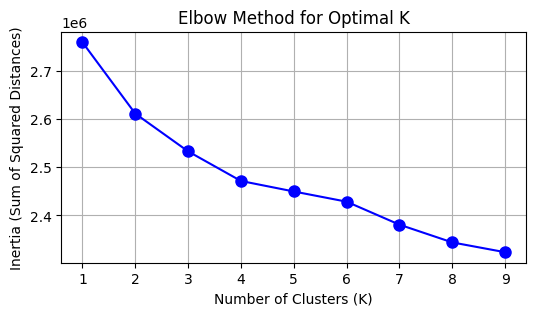

In [ ]:
# --- K-Means Optimization (Elbow Method) ---
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

print("Calculating Elbow Method for K-Means...")

inertia = []
K_range = range(1, 10) # Testing clusters from 1 to 9

for k in K_range:
    # Training K-Means on the unsupervised dataset
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_unsupervised)
    inertia.append(km.inertia_)

# Visualization
plt.figure(figsize=(6, 3))

# Plotting the Elbow Curve
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.xticks(K_range) # Ensure all K values are shown on X-axis

plt.show()

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-weight: bold; font-size: 16px; margin-bottom: 10px; color: white;">
10.1 Optimization Results: The Elbow Analysis
</div>

<div style="direction: ltr; text-align: left; font-family: 'Consolas', 'Courier New', monospace; font-size: 14px; line-height: 1.6; color: white;">

<b><u>GRAPH ANALYSIS (ELBOW METHOD)</b><br></u>
The chart above tracks the <b>Inertia</b> (Sum of Squared Distances) as we increase the number of clusters from K=1 to K=9.

<ul style="margin-top: 5px;">
  <li><b>Steep Decline (K=1 to 3):</b> We observe significant drops in inertia when moving from 1 to 2, and 2 to 3 clusters. This confirms that the data is definitely not uniform and has distinct subgroups.</li>
  <li><b>The "Elbow" Point (K=4):</b> The curve begins to flatten out (diminishing returns) around <b>K=4</b>. While inertia continues to decrease slightly after this point, the rate of improvement slows down.</li>
</ul>

<b><u>INSIGHT</b><br></u>
While our initial hypothesis used <code>K=2</code> (to match the binary "Murder vs. Non-Fatal" labels), the mathematics suggest that <b>K=4</b> might be the optimal number of natural clusters.
<br>
This implies that the "Murder" and "Non-Fatal" categories are likely not monolithic; instead, they might contain distinct sub-types of incidents (e.g., "Late Night Public Disputes" vs. "Residential Domestic Incidents") that group together spatially and temporally.

</div>